# Maize Plant Disease Detection Starter Notebook

## AI for Crop Health - Diagnosing Maize Plant Diseases in Zimbabwe Using Deep Learning

## 📌 Info Page

### About the Challenge
Maize is the staple crop that sustains millions of Zimbabweans, underpinning both food security and livelihoods across rural and urban communities. Yet, Zimbabwe’s maize production is persistently threatened by several devastating leaf diseases—primarily **Common Rust**, **Gray Leaf Spot**, and **Blight**—which cause significant yield reductions and economic losses.

These diseases are widespread across Zimbabwe’s diverse agro-ecological zones, including:
- High-rainfall areas like **Mashonaland East** and **Manicaland**.
- Drier regions like **Masvingo**.
- The central **Midlands**.

Their impact is exacerbated by limited access to timely and accurate disease diagnostics, especially for smallholder farmers who form the backbone of Zimbabwe’s agriculture.

### Your Task
Develop **deep learning models** that can accurately detect and classify maize diseases from leaf images. Leveraging AI for early and precise disease identification can transform farming practices by:
- Providing farmers with **real-time, accessible tools** to identify diseases before they spread widely.
- Reducing reliance on **manual inspection**, which is often subjective and slow.
- Enabling **targeted interventions** to minimize crop loss and reduce pesticide overuse.
- Contributing to **improved food security** and agricultural sustainability in Zimbabwe.

### Dataset Overview
The dataset includes images of maize leaves categorized into:
1. **Common Rust**
2. **Gray Leaf Spot**
3. **Blight**
4. **Healthy**

Your challenge is to design and train models robust to diverse field conditions (e.g., varying lighting, leaf angles, and disease severity).

### Impact
By addressing this challenge, you will contribute to a **high-impact solution** with direct applications in Zimbabwe’s farming communities and beyond, driving the adoption of AI-powered precision agriculture in sub-Saharan Africa.


## 📊 Evaluation
- **Metrics**: Accuracy, Precision, Recall, F1-Score.
- **Leaderboard**: Based on performance on the evaluation set.
# 
### 🏆 Prizes
 - **Top 3 performers** will receive:
   - Official certification of achievement
   - Recognition on our community platforms
   - Priority consideration for future opportunities with:
     - The Deep Learning Indaba X Zimbabwe community
     - Agricultural sector partners

## ⏳ Timeline
- **Start Date**: [Insert Date]
- **Submission Deadline**: [Insert Date]
- **Results Announcement**: [Insert Date]

## 📜 Rules
- This challenge is **only open to the Deep Learning Indaba X Zimbabwe Community**.
- Teams must adhere to the **code of conduct** and **submission guidelines**.


## 📂 Data Page

### About the Data
The dataset contains labelled images of crop leaves, categorized into four classes:

 | Class          | Training Images | Validation Images | Test Images | Total Images |
 |----------------|------------------|-------------|-------------------|--------------|
 | Common Rust    | 914              | 197         | -                 | 1,111        |
 | Gray Leaf Spot | 401              | 87          | -                 | 488          |
 | Blight         | 802              | 173         | -                 | 975          |
 | Healthy        | 813              | 175         | -                 | 988          |
 | Unlabeled      | -                | -           | 626               | 626          |





# 🌱 Starter Notebook:  Maize Plant Disease Detection 

## 📌 Overview
This notebook serves as a **starter template** for the *AI for Crop Health* hackathon challenge. It provides a foundational workflow for loading, preprocessing, and analyzing the maize disease dataset, as well as training a baseline deep learning model. Use this as a jumping-off point to build and refine your solution.


## 🎯 Objectives
By the end of this notebook, you will:
1. **Explore the dataset**: Visualize sample images and understand class distributions.
2. **Preprocess data**: Resize, normalize, and augment images for model training.
3. **Train a baseline model**: Implement a simple CNN or transfer learning model.
4. **Evaluate performance**: Calculate metrics (accuracy, F1-score) and identify areas for improvement.



## **Importing Libraries**

In [22]:
import os

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import PIL
import torch
import torch.nn as nn
import torch.optim as optim
import torchinfo
import torchvision
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from torch.utils.data import DataLoader, random_split
from torchinfo import summary
from torchvision import datasets, transforms
from tqdm import tqdm
from sklearn.metrics import classification_report

In [2]:
# Check for available hardware acceleration and set device accordingly

if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"


### **Exploring and Preparing Our Data**

In [3]:
# Define paths to training and val data directories
# Using os.path.join() ensures cross-platform compatibility for path construction
train_data_dir = os.path.join("crop pictures", "train")  # Path to training data
val_data_dir = os.path.join("crop pictures", "val")    # Path to val data

# Print the paths for verification and debugging purposes
print("Training Data Directory:", train_data_dir)  # Show training data path
print("val Data Directory:", val_data_dir)       # Show val data path

Training Data Directory: crop pictures\train
val Data Directory: crop pictures\val


In [4]:
#Create and print a list of class names in our directory
classes = os.listdir(train_data_dir)

print("List of classes:", classes)


List of classes: ['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']


In [5]:
# Count number of images in each class for train and val sets
train_counts = {}
val_counts = {}

for class_name in classes:
    train_class_dir = os.path.join(train_data_dir, class_name)
    val_class_dir = os.path.join(val_data_dir, class_name)
    
    train_counts[class_name] = len(os.listdir(train_class_dir))
    val_counts[class_name] = len(os.listdir(val_class_dir))

print("Training set counts:")
for class_name, count in train_counts.items():
    print(f"{class_name}: {count} images")

print("\nValidation set counts:") 
for class_name, count in val_counts.items():
    print(f"{class_name}: {count} images")


Training set counts:
Blight: 802 images
Common_Rust: 914 images
Gray_Leaf_Spot: 401 images
Healthy: 813 images

Validation set counts:
Blight: 173 images
Common_Rust: 197 images
Gray_Leaf_Spot: 87 images
Healthy: 175 images


## **Image Preprocessing**

In [6]:
# Convert grayscale images to RGB format since our model expects 3-channel input
# Grayscale images only have 1 channel, which would cause dimension mismatch errors
# This ensures all images have consistent 3-channel RGB format for model training
def convert_to_rgb(img):
    """Convert PIL image to RGB format if it isn't already.
    
    Args:
        img: PIL Image object
    
    Returns:
        PIL Image object in RGB format
    """
    if img.mode != "RGB":
        img = img.convert("RGB")
    return img

In [7]:
def get_mean_std(loader):
    """Computes the mean and standard deviation of image data.

    Input: a `DataLoader` producing tensors of shape [batch_size, channels, pixels_x, pixels_y]
    Output: the mean of each channel as a tensor, the standard deviation of each channel as a tensor
            formatted as a tuple (means[channels], std[channels])"""

    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for data, _ in tqdm(loader, desc="Computing mean and std", leave=False):
        channels_sum += torch.mean(data, dim=[0, 2, 3])
        channels_squared_sum += torch.mean(data**2, dim=[0, 2, 3])
        num_batches += 1
    mean = channels_sum / num_batches
    std = (channels_squared_sum / num_batches - mean**2) ** 0.5

    return mean, std

In [8]:
# Resize images to 224x224 to ensure consistent input dimensions for the model (common size for CNNs)
# Convert images to tensors to enable GPU acceleration and matrix operations
# First create a basic transform to get images to tensor format for mean/std calculation


# Final transform with calculated normalization values
transform = transforms.Compose([
    transforms.Lambda(convert_to_rgb),  # First convert to RGB if needed
    transforms.Resize((224, 224)),      # Resize to 224x224
    transforms.ToTensor(),              # Convert to tensor
])


print(type(transform))
print("-----------------")
print(transform)

<class 'torchvision.transforms.transforms.Compose'>
-----------------
Compose(
    Lambda()
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [9]:
# Create training and validation datasets using ImageFolder with the defined transform
training_dataset = datasets.ImageFolder(train_data_dir,transform)
val_dataset = datasets.ImageFolder(val_data_dir,transform)
print('Length of training dataset:', len(training_dataset))
print('Length of validation dataset:', len(val_dataset))

Length of training dataset: 2930
Length of validation dataset: 632


Computing class counts for training data...
Training data counts:
Blight            802
Common_Rust       914
Gray_Leaf_Spot    401
Healthy           813
dtype: int64

Computing class counts for val data...
Validation data counts:
Blight            173
Common_Rust       197
Gray_Leaf_Spot     87
Healthy           175
dtype: int64


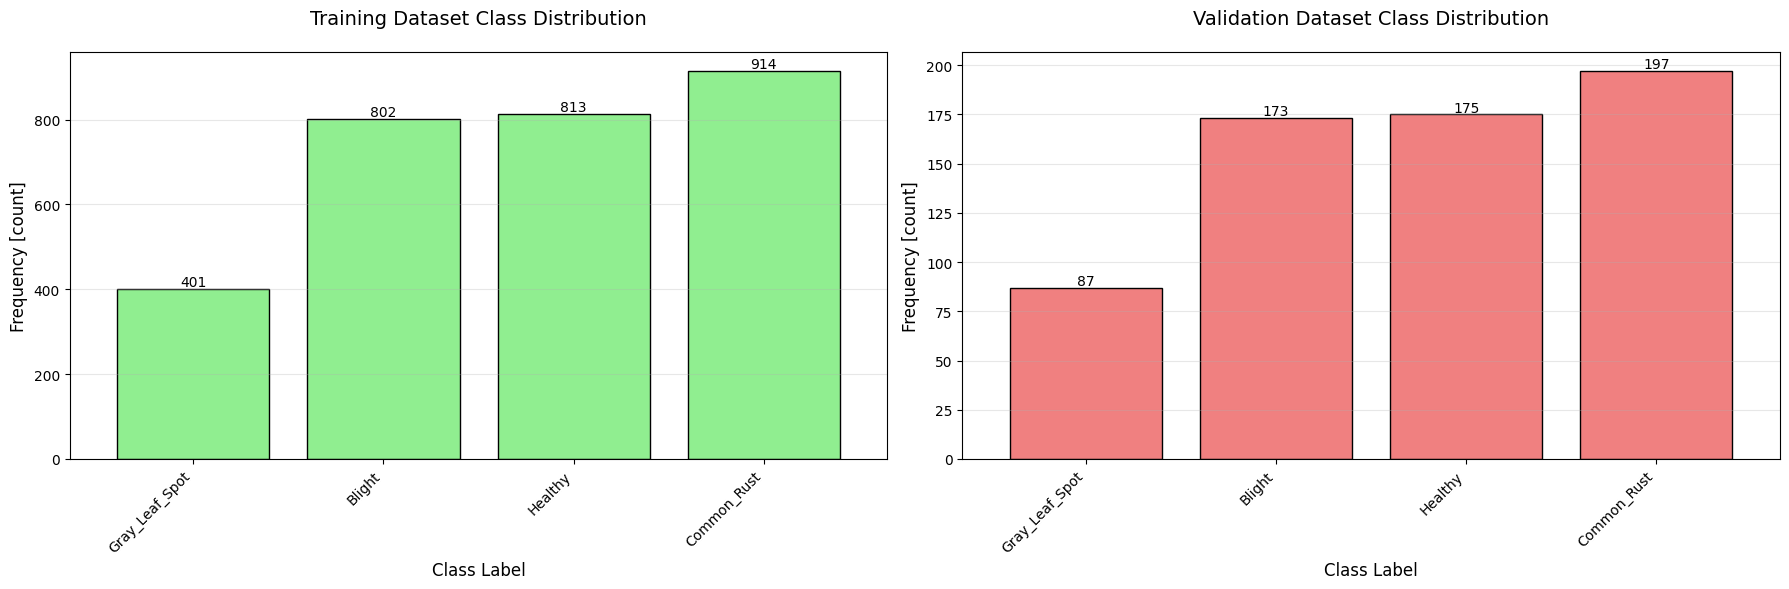

In [10]:
# This section analyzes and visualizes the class distribution in our training and validation datasets

# Function to count instances of each class in a dataset
def class_counts(dataset):
    """Counts the number of samples per class in a dataset.
    
    Args:
        dataset: A PyTorch Dataset object with class labels
        
    Returns:
        A pandas Series with class names as index and counts as values
    """
    counts = {}
    for _, label in dataset:
        class_name = dataset.classes[label]  # Get class name from label index
        counts[class_name] = counts.get(class_name, 0) + 1  # Increment count
    return pd.Series(counts)

# Calculate and display class counts for both datasets
print("Computing class counts for training data...")
train_counts = class_counts(training_dataset)
print("Training data counts:")
print(train_counts)
print("\nComputing class counts for val data...")
val_counts = class_counts(val_dataset)
print("Validation data counts:")
print(val_counts)

# Create visualization comparing class distributions
plt.figure(figsize=(18, 6))  # Set figure size

# Training data distribution plot
plt.subplot(1, 2, 1)  # First subplot
ax1 = train_counts.sort_values().plot(
    kind='bar',
    color='lightgreen',
    edgecolor='black',
    width=0.8
)
# Add count labels above bars
for p in ax1.patches:
    ax1.annotate(str(p.get_height()), 
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', 
                xytext=(0, 5), 
                textcoords='offset points')
plt.xlabel("Class Label", fontsize=12)
plt.ylabel("Frequency [count]", fontsize=12)
plt.title("Training Dataset Class Distribution", fontsize=14, pad=20)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels
plt.grid(axis='y', alpha=0.3)  # Add light grid lines

# Validation data distribution plot
plt.subplot(1, 2, 2)  # Second subplot
ax2 = val_counts.sort_values().plot(
    kind='bar',
    color='lightcoral',
    edgecolor='black',
    width=0.8
)
# Add count labels above bars
for p in ax2.patches:
    ax2.annotate(str(p.get_height()), 
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', 
                xytext=(0, 5), 
                textcoords='offset points')
plt.xlabel("Class Label", fontsize=12)
plt.ylabel("Frequency [count]", fontsize=12)
plt.title("Validation Dataset Class Distribution", fontsize=14, pad=20)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels
plt.grid(axis='y', alpha=0.3)  # Add light grid lines

plt.tight_layout()  # Adjust spacing between subplots
plt.show()  # Display the figure

In [11]:
# Set batch size for data loading
batch_size = 32

# Create training data loader with shuffling for better training
train_loader = DataLoader(training_dataset, batch_size, shuffle=True)

# Create validation data loader without shuffling for consistent evaluation
val_loader = DataLoader(val_dataset, batch_size, shuffle=False)

# Print types of the created data loaders
print(type(train_loader))
print(type(val_loader))

<class 'torch.utils.data.dataloader.DataLoader'>
<class 'torch.utils.data.dataloader.DataLoader'>


In [12]:
# Get first batch of training data to inspect shapes
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Print image batch shape (batch_size, channels, height, width)
print(f"Image batch shape: {images.shape} (batch_size, channels, height, width)")

# Print label batch shape (batch_size,)
print(f"Label batch shape: {labels.shape} (batch_size,)")

Image batch shape: torch.Size([32, 3, 224, 224]) (batch_size, channels, height, width)
Label batch shape: torch.Size([32]) (batch_size,)


## Model Building -Simple Convolutional Neural Network

In [13]:
model = torch.nn.Sequential(
    # Minimal convolutional block
    nn.Conv2d(3, 8, kernel_size=3, padding=1),  # Reduced channels
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    
    # Single fully-connected layer
    nn.Flatten(),
    nn.Linear(8 * 112 * 112, 4)  # Direct to output with reduced dimensions
)
print(model)


Sequential(
  (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Flatten(start_dim=1, end_dim=-1)
  (4): Linear(in_features=100352, out_features=4, bias=True)
)


## Training Our Model

In [14]:
# Initialize loss function - CrossEntropyLoss is suitable for multi-class classification
# This will measure how well our model's predictions match the true disease labels
loss_fn = nn.CrossEntropyLoss()

# Set up Adam optimizer with learning rate 0.01 to update model parameters during training
# Adam is an adaptive optimizer that adjusts learning rates per-parameter
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Print details of our training configuration
print("Training Configuration:")
print(f"Loss Function: {loss_fn}")
print("----------------------")
print(f"Optimizer: {optimizer} (Learning Rate: 0.01)")

Training Configuration:
Loss Function: CrossEntropyLoss()
----------------------
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0
) (Learning Rate: 0.01)


In [15]:
# Define input dimensions for the model summary
height = 224  # Height of input images in pixels
width = 224   # Width of input images in pixels

# Generate model summary showing:
# - Layer architecture
# - Output shapes
# - Parameter counts
# - Memory usage
# Input size format: (batch_size, channels, height, width)
summary(model, input_size=(batch_size, 3, height, width))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [32, 4]                   --
├─Conv2d: 1-1                            [32, 8, 224, 224]         224
├─ReLU: 1-2                              [32, 8, 224, 224]         --
├─MaxPool2d: 1-3                         [32, 8, 112, 112]         --
├─Flatten: 1-4                           [32, 100352]              --
├─Linear: 1-5                            [32, 4]                   401,412
Total params: 401,636
Trainable params: 401,636
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 372.51
Input size (MB): 19.27
Forward/backward pass size (MB): 102.76
Params size (MB): 1.61
Estimated Total Size (MB): 123.64

In [16]:
def train(
    model,
    optimizer,
    loss_fn,
    train_loader,
    val_loader,
    epochs=5,
    device='cpu',
    use_train_accuracy=True,
):
    """Train a PyTorch model and validate its performance.
    
    Args:
        model: The neural network model to train
        optimizer: Optimization algorithm (e.g., Adam)
        loss_fn: Loss function (e.g., CrossEntropyLoss)
        train_loader: DataLoader for training data
        val_loader: DataLoader for validation data
        epochs: Number of training iterations (default: 5)
        device: Device to train on ('cpu' or 'cuda')
        use_train_accuracy: Whether to compute training accuracy (default: True)
    
    Returns:
        Tuple of lists containing training/validation losses and accuracies
    """
    # Move model to specified device (CPU/GPU)
    model.to(device)
    
    # Initialize lists to track performance metrics
    train_losses = []  # Training loss per epoch
    val_losses = []    # Validation loss per epoch
    train_accuracies = []  # Training accuracy per epoch
    val_accuracies = []    # Validation accuracy per epoch
    
    # Training loop over specified number of epochs
    for epoch in range(epochs):
        # --- TRAINING PHASE ---
        model.train()  # Set model to training mode
        train_loss = 0.0
        correct_train = 0
        total_train = 0
        
        # Iterate over training batches
        for inputs, labels in train_loader:
            # Move data to device
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Reset gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            # Calculate loss
            loss = loss_fn(outputs, labels)
            # Backward pass (compute gradients)
            loss.backward()
            # Update weights
            optimizer.step()
            
            # Accumulate loss
            train_loss += loss.item()
            
            # Calculate training accuracy if enabled
            if use_train_accuracy:
                _, predicted = torch.max(outputs.data, 1)  # Get predicted class
                total_train += labels.size(0)  # Total samples in batch
                correct_train += (predicted == labels).sum().item()  # Correct predictions
        
        # --- VALIDATION PHASE ---
        model.eval()  # Set model to evaluation mode
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        
        # Disable gradient calculation for validation
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                
                # Forward pass
                outputs = model(inputs)
                # Calculate loss
                loss = loss_fn(outputs, labels)
                val_loss += loss.item()
                
                # Calculate validation accuracy
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
        
        # --- METRICS CALCULATION ---
        # Average losses over all batches
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        # Calculate accuracies (percentage)
        if use_train_accuracy:
            train_acc = 100 * correct_train / total_train
            train_accuracies.append(train_acc)
        val_acc = 100 * correct_val / total_val
        val_accuracies.append(val_acc)
        
        # Print epoch statistics
        print(f'Epoch {epoch+1}/{epochs}')
        print(f'Train Loss: {train_loss:.4f}', end=' ')
        if use_train_accuracy:
            print(f'- Train Acc: {train_acc:.2f}%', end=' ')
        print(f'- Val Loss: {val_loss:.4f} - Val Acc: {val_acc:.2f}%')
    
    return train_losses, val_losses, train_accuracies, val_accuracies

# Execute training with default 5 epochs
train_losses, val_losses, train_accuracies, val_accuracies = train(
    model, optimizer, loss_fn, train_loader, val_loader, epochs=5
)


Epoch 1/5
Train Loss: 3.6033 - Train Acc: 57.44% - Val Loss: 0.7822 - Val Acc: 57.91%
Epoch 2/5
Train Loss: 0.7992 - Train Acc: 64.37% - Val Loss: 0.7398 - Val Acc: 68.20%
Epoch 3/5
Train Loss: 0.6938 - Train Acc: 72.08% - Val Loss: 0.7423 - Val Acc: 68.20%
Epoch 4/5
Train Loss: 0.4320 - Train Acc: 84.16% - Val Loss: 0.5852 - Val Acc: 78.80%
Epoch 5/5
Train Loss: 0.3074 - Train Acc: 89.22% - Val Loss: 0.7661 - Val Acc: 75.00%


### **Model Evalutions**

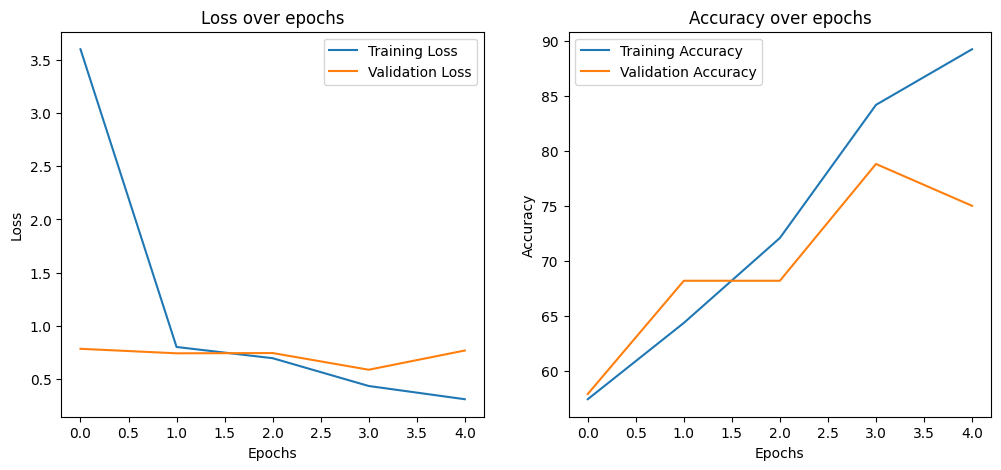

In [17]:

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Loss over epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Training Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.title("Accuracy over epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

### Overall Assessment
**Overfitting**: The graphs indicate a significant divergence between training and validation metrics, suggesting potential overfitting. The model shows strong performance on the training data, but validation accuracy plateaus while training accuracy continues to improve.

### Next Steps:
1. **Regularization**: Implement techniques such as dropout or L2 regularization to help mitigate overfitting.
2. **Data Augmentation**: Introduce data augmentation strategies to enhance the diversity of the training dataset, which may improve generalization.
3. **Early Stopping**: Consider using early stopping based on validation loss to halt training when performance on the validation set begins to degrade.
4. **Hyperparameter Tuning**: Explore different learning rates, batch sizes, and model architectures to optimize performance.


In [18]:
def predict(model, data_loader):
    model.eval()
    all_probs = []
    with torch.no_grad():
        for images, _ in data_loader:
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            all_probs.append(probs)
    return torch.cat(all_probs, dim=0)

probabilities_val = predict(model, val_loader)
predictions_val = torch.argmax(probabilities_val, dim=1)

print(predictions_val)

tensor([0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 3, 0, 0, 0, 3, 3, 1, 1, 0, 3, 0, 3, 3, 1,
        3, 3, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 3, 3, 3, 0, 0, 0, 0, 0,
        3, 3, 2, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 3, 0, 0, 3, 3, 0, 3, 2, 0, 0, 3,
        2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 3, 0, 0, 0, 0, 3, 0, 0, 0, 3, 3, 0, 0, 3,
        0, 3, 0, 0, 0, 0, 0, 3, 2, 0, 3, 0, 3, 0, 0, 0, 0, 0, 3, 0, 0, 3, 0, 3,
        3, 0, 0, 0, 0, 3, 3, 0, 0, 3, 0, 2, 3, 3, 0, 3, 2, 0, 0, 2, 0, 0, 0, 1,
        3, 3, 0, 0, 0, 0, 0, 3, 0, 0, 0, 3, 2, 3, 0, 0, 3, 0, 0, 3, 0, 3, 3, 3,
        3, 0, 0, 2, 3, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 0, 3, 3, 1, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [19]:
targets_val = torch.cat(
    [labels for _, labels in tqdm(val_loader, desc="Get Labels")]
)

Get Labels: 100%|██████████| 20/20 [00:01<00:00, 10.15it/s]


<Figure size 1000x800 with 0 Axes>

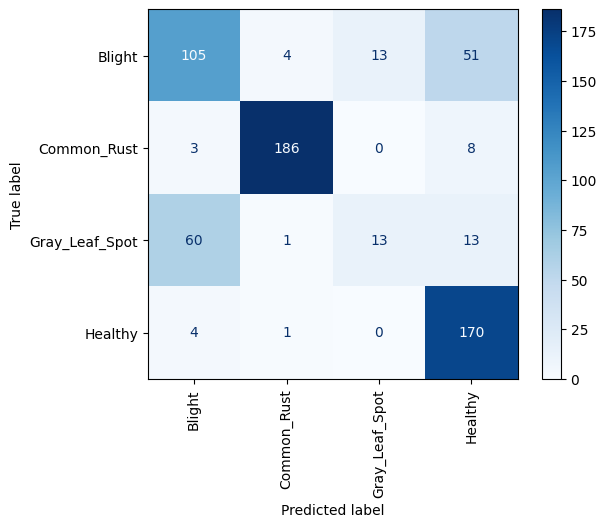

In [20]:
cm = confusion_matrix(targets_val.cpu(), predictions_val.cpu())

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)

# Set figure size
plt.figure(figsize=(10, 8))

disp.plot(cmap=plt.cm.Blues, xticks_rotation="vertical")
plt.show()

In [21]:
# Generate classification report
report = classification_report(targets_val.cpu(), predictions_val.cpu(), target_names=classes)
print(report)


                precision    recall  f1-score   support

        Blight       0.61      0.61      0.61       173
   Common_Rust       0.97      0.94      0.96       197
Gray_Leaf_Spot       0.50      0.15      0.23        87
       Healthy       0.70      0.97      0.82       175

      accuracy                           0.75       632
     macro avg       0.70      0.67      0.65       632
  weighted avg       0.73      0.75      0.72       632



## Submission to Hackathon

In [32]:
# Define the directory for test images
test_dir = os.path.join('crop pictures', 'test')

# Print the test directory path
print(test_dir)

crop pictures\test


In [34]:
# Define a function to get the confidence scores for a given image file
def file_to_confidence(model, datadir, filename, transform_pipeline):
    # Construct the full file path for the image
    file_path = os.path.join(datadir, filename)
    # Open the image file
    image = PIL.Image.open(file_path)
    # Apply the transformation pipeline to the image
    transformed = transform_pipeline(image)
    # Add a batch dimension to the transformed image
    unsqueezed = transformed.unsqueeze(0)
    # Move the image tensor to the appropriate device (CPU or GPU)
    image_cuda = unsqueezed.to(device)

    # Set the model to evaluation mode
    model.eval()
    # Disable gradient calculation for inference
    with torch.no_grad():
        # Get the raw output from the model
        model_raw = model(image_cuda)
        # Apply softmax to get confidence scores for each class
        confidence = torch.nn.functional.softmax(model_raw, dim=1)

    # Create a DataFrame to store the filename and confidence scores
    conf_df = pd.DataFrame([[filename] + confidence.tolist()[0]])
    # Set the column names to include the image ID and class names
    conf_df.columns = ["ID"] + training_dataset.classes

    # Return the DataFrame containing the confidence scores
    return conf_df

In [35]:
# This section retrieves the directory of blight training images and gets the confidence score for a specific image.
blight_train_dir = os.path.join('crop pictures','train','blight')
blight_images = os.listdir(blight_train_dir)

file_to_confidence(model, blight_train_dir, blight_images[7], transform)

,ID,Blight,Common_Rust,Gray_Leaf_Spot,Healthy
0,Corn_Blight (1007).JPG,0.66647,0.05302,0.13480,0.14572


In [37]:
# Convert scientific notation to standard decimals
pd.set_option('display.float_format', lambda x: '%.5f' % x)

# Final prediction to hackathon
small_dfs = []

for filename in tqdm(os.listdir(test_dir), desc="Predicting on test set"):
    small_dfs.append(
        file_to_confidence(model, test_dir, filename, transform)
    )

confidence_df = pd.concat(small_dfs)

confidence_df = confidence_df.sort_values("ID").reset_index(drop=True)
confidence_df.head()

Predicting on test set: 100%|██████████| 626/626 [00:03<00:00, 165.67it/s]


,ID,Blight,Common_Rust,Gray_Leaf_Spot,Healthy
0,image_000001.jpg,0.73140,0.01391,0.23257,0.02212
1,image_000002.JPG,0.00108,0.00085,0.00012,0.99795
2,image_000003.JPG,0.00000,1.00000,0.00000,0.00000
3,image_000004.JPG,0.26471,0.03529,0.06836,0.63164
4,image_000005.JPG,0.00045,0.00035,0.00012,0.99908


In [ ]:
confidence_df.to_csv("submission.csv", index=False)